# Task 4.1

In [2]:
import pandas as pd
import tslearn
import numpy as np
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import LabelBinarizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn import tree
from sklearn import svm

In [3]:
df = pd.read_csv("../data/CityGlobalTemperature2000-2009.csv", parse_dates=['time'])
df

,Unnamed: 0,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,time
0,1813,27.685,0.267,Abidjan,Côte D'Ivoire,5.63N,3.23W,2000-02-01
1,1814,29.061,0.224,Abidjan,Côte D'Ivoire,5.63N,3.23W,2000-03-01
2,1815,28.162,0.478,Abidjan,Côte D'Ivoire,5.63N,3.23W,2000-04-01
3,1816,27.547,0.509,Abidjan,Côte D'Ivoire,5.63N,3.23W,2000-05-01
4,1817,25.812,0.231,Abidjan,Côte D'Ivoire,5.63N,3.23W,2000-06-01
...,...,...,...,...,...,...,...,...
11995,239128,18.459,0.374,Xian,China,34.56N,108.97E,2009-09-01
11996,239129,14.195,0.163,Xian,China,34.56N,108.97E,2009-10-01
11997,239130,2.916,0.675,Xian,China,34.56N,108.97E,2009-11-01
11998,239131,-0.712,0.259,Xian,China,34.56N,108.97E,2009-12-01


Breaking original dataframe into time series, one per city.

In [4]:
ts_for_city = {}

In [5]:
for city in df['City'].unique():
    ts_for_city[city] = df[df['City'] == city]['AverageTemperature'].tolist()

In [6]:
ts_dataset = to_time_series_dataset(list(ts_for_city.values()))

In [7]:
km = TimeSeriesKMeans(n_clusters=3, metric="dtw")
km.fit(ts_dataset)

TimeSeriesKMeans(metric='dtw')

In [8]:
df_label = df
i = 0
for city in df['City'].unique():
    df_label.loc[df_label['City'] == city,'label'] = km.labels_[i]
    i += 1


<AxesSubplot:xlabel='time', ylabel='AverageTemperature'>

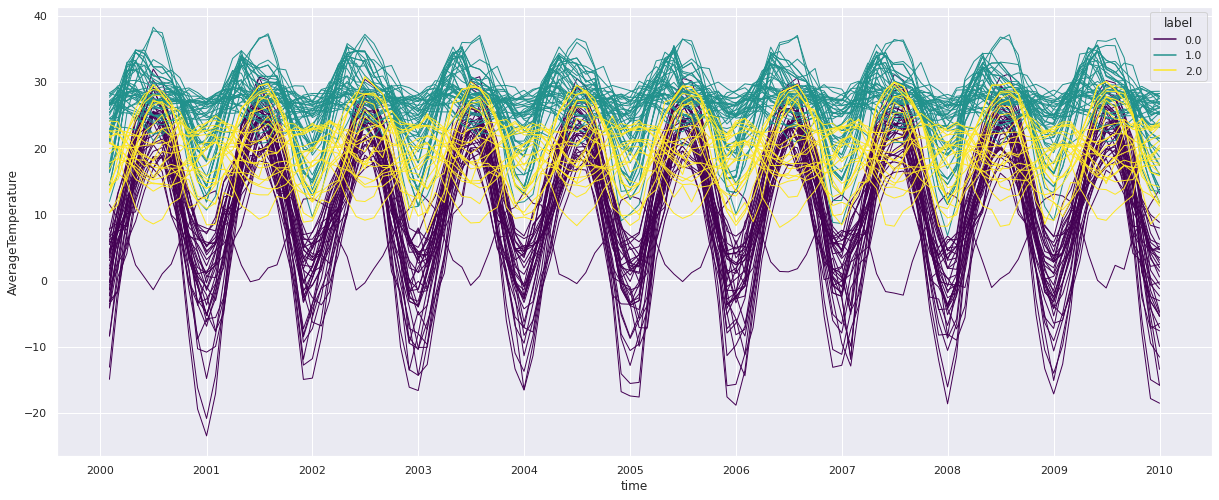

In [9]:
import seaborn as sns
sns.set(rc={'figure.figsize':(20.7,8.27)})
sns.color_palette("rocket", as_cmap=True)

sns.lineplot(
    data=df_label,
    x="time", y="AverageTemperature", hue="label", units="City",
    estimator=None, lw=1, 
    palette = sns.color_palette("viridis", as_cmap=True)
)

In [10]:
df_label[df_label['label'] == 1]['City'].unique()

array(['Abidjan', 'Ahmadabad', 'Baghdad', 'Bangalore', 'Bangkok',
       'Bombay', 'Calcutta', 'Dakar', 'Dar Es Salaam', 'Delhi', 'Dhaka',
       'Faisalabad', 'Fortaleza', 'Ho Chi Minh City', 'Hyderabad',
       'Ibadan', 'Jaipur', 'Jakarta', 'Jiddah', 'Kano', 'Kanpur',
       'Karachi', 'Kinshasa', 'Lagos', 'Lahore', 'Lakhnau', 'Luanda',
       'Madras', 'Manila', 'Mogadishu', 'Nagpur', 'New Delhi', 'Pune',
       'Rangoon', 'Rio De Janeiro', 'Riyadh', 'Salvador', 'Santo Domingo',
       'Singapore', 'Surabaya', 'Surat', 'Umm Durman'], dtype=object)

# Task 4.2

## SHAP

In [39]:
import shap # v0.39.0
shap.initjs()

## Models ##

#### Loading and splitting the dataset ####

In [13]:
df = pd.read_csv("../data/df_male_classification.csv")
X = np.array(df.drop(columns = ['label']))
y = np.array(df['label'])
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7)
df_X_train = pd.DataFrame(X_train, columns=['IOC','Won_Tournaments','Number_of_Matches','Win_Percentage'])
df_X_test = pd.DataFrame(X_test, columns=['IOC','Won_Tournaments','Number_of_Matches','Win_Percentage'])

#### Neural networks #####

In [14]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs',learning_rate= 'adaptive', alpha=2e-5, hidden_layer_sizes=(10, 20), random_state=1, validation_fraction=0.25, early_stopping=True, max_iter=400)
clf.fit(X_train, y_train)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


MLPClassifier(alpha=2e-05, early_stopping=True, hidden_layer_sizes=(10, 20),
              learning_rate='adaptive', max_iter=400, random_state=1,
              solver='lbfgs', validation_fraction=0.25)

In [15]:
nn_explainer = shap.KernelExplainer(clf.predict, df_X_train)

Using 1110 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [16]:
shap_values = nn_explainer.shap_values(df_X_test)

  0%|          | 0/370 [00:00<?, ?it/s]

In [43]:
shap.force_plot(nn_explainer.expected_value, shap_values,df_X_test)


In [31]:
type(shap_values)

numpy.ndarray

### KNN ###

In [17]:
neigh = KNeighborsClassifier(n_neighbors=7, metric='minkowski', p=3)
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=7, p=3)

In [18]:
f = lambda x: neigh.predict_proba(x)[:,1]
explainer = shap.Explainer(f, df_X_train)

In [34]:
knn_shap_values = explainer(df_X_test)

X has feature names, but KNeighborsClassifier was fitted without feature names
X has feature names, but KNeighborsClassifier was fitted without feature names
X has feature names, but KNeighborsClassifier was fitted without feature names
X has feature names, but KNeighborsClassifier was fitted without feature names
X has feature names, but KNeighborsClassifier was fitted without feature names
X has feature names, but KNeighborsClassifier was fitted without feature names
X has feature names, but KNeighborsClassifier was fitted without feature names
X has feature names, but KNeighborsClassifier was fitted without feature names
X has feature names, but KNeighborsClassifier was fitted without feature names
X has feature names, but KNeighborsClassifier was fitted without feature names
X has feature names, but KNeighborsClassifier was fitted without feature names
X has feature names, but KNeighborsClassifier was fitted without feature names
X has feature names, but KNeighborsClassifier was fi

shap._explanation.Explanation

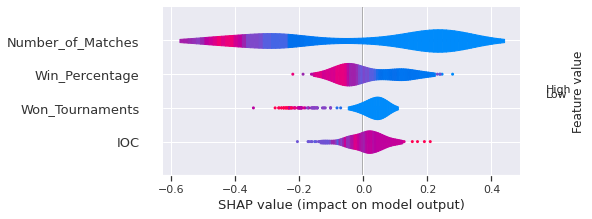

In [ ]:
#shap.plots.waterfall(shap_values[43])
#shap.summary_plot(shap_values, df_X_test)
shap.summary_plot(shap_values, df_X_test, plot_type='violin')

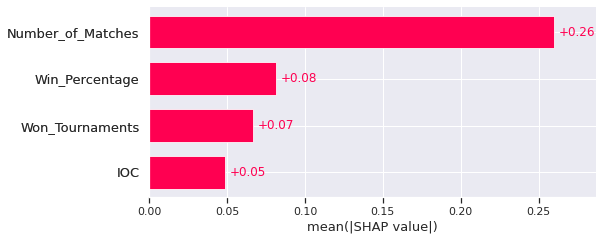

In [ ]:
shap.plots.bar(shap_values)

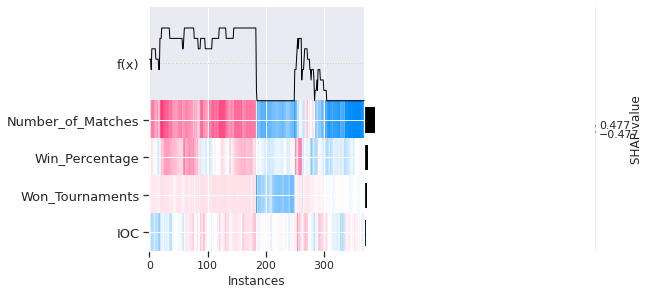

In [ ]:
shap.plots.heatmap(shap_values)

### SVM ###

In [ ]:
clf = svm.SVC()
clf.fit(X_train, y_train)

SVC()

### Tree models ###

In [ ]:
tree = tree.DecisionTreeClassifier(max_depth=1, max_features=4)
tree = tree.fit(X_train, y_train)

In [ ]:
explainer = 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=de87b132-0371-4d99-94f9-c61923e2507d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>